# Нелинейное снижение размерности методом Isomap

![isomap](pictures/intro.jpg)

### Багаев Д.В.

## Non-linear dimensionality reduction

#### Problem

High-dimensional data, meaning data that requires more than two or three dimensions to represent, can be difficult to interpret. One approach to simplification is to assume that the data of interest lie on an embedded non-linear manifold within the higher-dimensional space. If the manifold is of low enough dimension, the data can be visualised in the low-dimensional space.

## Non-linear dimensionality reduction
* Based on assumption that original data $x \in R^D $ is distributed compactly on non-linear surface with dimensionality $d < D$
* Let $ y \in R^d $ denote the coordinates of $x$ on the surface
* Sample dataset:
![isomap](pictures/s.jpg)
* Linear dimensionality reduction techniques will fail here

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

class RowImages():
    def __init__(self, images, columns = 5, size = (20, 10)):
        self.images = images
        self.columns = columns
        self.size = size
        
    def show(self, cmap = None):
        images = []
        if type(self.images[0][0]) is str:
            for img_path in map(lambda x: x[0], self.images):
                images.append(mpimg.imread(img_path))
        else:
            images = list(map(lambda x: x[0], self.images))
            
        plt.figure(figsize=self.size)
        titles = list(map(lambda x: x[1], self.images))
        for i, image in enumerate(images):
            subplot = plt.subplot(len(images) / self.columns + 1, self.columns, i + 1)
            subplot.set_title(titles[i])
            subplot.axis("off")
            _ = plt.imshow(image, cmap = cmap)

In [2]:
typicalDatasetsImages = [
    ('pictures/isomap-graph.png', ''), 
    ('pictures/swiss-roll.png', 'Swiss roll dataset'), 
    ('pictures/helix.png', 'Helix dataset'),
    ('pictures/twinpeaks.png', 'Twinpeaks dataset'),
    ('pictures/broken-swiss.png', 'Broken Swiss dataset')
]

typicalDatasets = RowImages(typicalDatasetsImages, columns = 3)

Typical datasets for dimensionality reduction evaluation


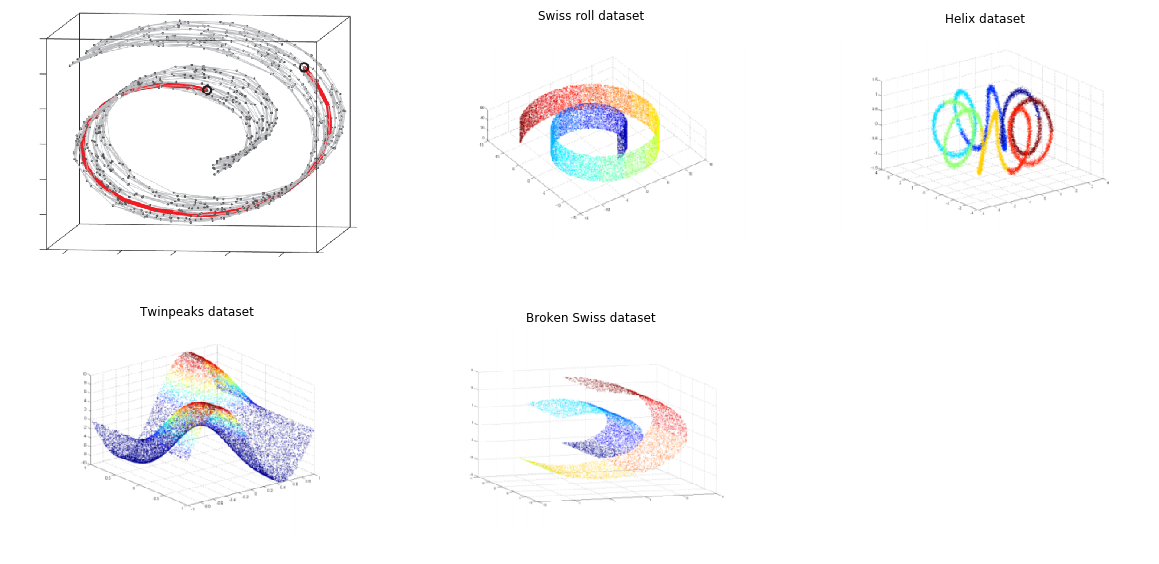

In [3]:
print("Typical datasets for dimensionality reduction evaluation")
typicalDatasets.show()

** Comment **: True datasets have much more dimensions, more complex structure, errors, outliers etc.

## Multi-dimensional scaling

Map $x\rightarrow y$ preserving distances as much as possible.

* Approaches:
    * absolute difference 
        $$ \sum_{i,j} (||x_i - x_j|| - ||y_i - y_j||)^2 \rightarrow \min_Y  $$
    * relative difference (more attention to small distances)
        $$ \sum_{i,j} \frac{(||x_i - x_j|| - ||y_i - y_j||)^2}{||x_i - x_j||^2} \rightarrow \min_Y $$

## Analysis
![Issue](pictures/issue.png)
**Issue**: small $||x_i - x_j||$ should not always imply small $||y_i - y_j||$

## Solution
** Isomap **: Map $x \Rightarrow y$ preserving correspondence beetwen distance in target space and geodesic distance along the surface in original space.
![Solution](pictures/solution.png)

## Isomap

We can view the problem of manifold learning as an attempt to invert a generative model for a set of observations. Let $Y$ be a $d$-dimensional domain contained in the Euclidean space $R^d$, and let $f: Y \Rightarrow R^D$ be a smooth embedding, for some $D>d$. The object of manifold learning is to recover $Y$ and $f$ based on a given set {$x_i$} of observed data in $R^D$. The observed data arise as follows. Hidden data {$y_i$} are generated randomly in $Y$, and are then mapped by $f$ to become the observed data, so {$x_i=f(y_i)$}.

** Algorithm **:
There are four stages to Isomap:
1. Determine a __neighbourhood graph__ $G$ of the observed data {$x_i$} in a suitable way. For example, $G$ might contain $x_ix_j$ iff $x_j$ is one of the $k$ nearest neighbours of $x_i$ (and vice versa). Alternatively, $G$ might contain the edge $x_ix_j$ iff $||x_i - x_j|| < \varepsilon $ for some $\varepsilon$.
2. For each $x_i$ find its $K$ nearest neighbours 
3. Compute shortes paths in the graph for all pairs of data points. Each edge $x_ix_j$ in the graph is weighted by its Euclidean length $|x_i - x_j|$, or by some other useful metric. Here Dijkstra or Floyd algorithms can be used.
4. Apply MDS to the resulting shortest-path distance matrix D to find new embedding of the data in Euclidien space, apporimating $Y$.

## Issues of Isomap

* Noisy observations beetwen distant parts of surfaces may make distant parts close
* Solutions
    * remove observations with large total flows through them
    * remove nearest neighbours that vilate local linaerity
* Selection of $K$
    * if too small, then poor approximation of geodesic distance
    * if too large, then increases chance of "short-circuiting" through noisy observations.

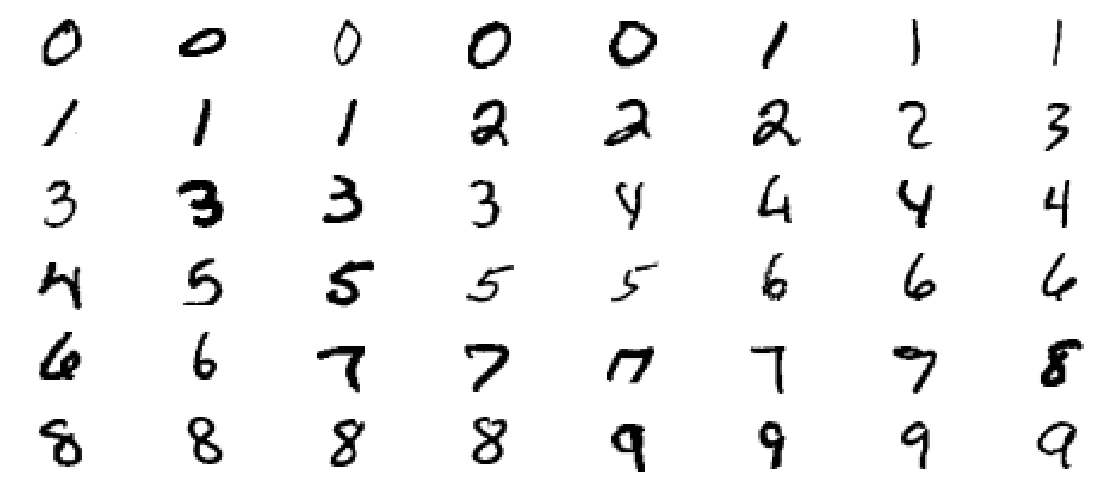

In [4]:
from sklearn.datasets import fetch_mldata
import numpy as np
mnist = fetch_mldata('MNIST original', data_home="./")
numberImages = []
for i in range(48):
    numberImages.append((mnist.data[1250 * i].reshape(28, 28), ''))
images = RowImages(numberImages, columns = 8)
images.show(cmap='gray_r')

In [5]:
from matplotlib import offsetbox

class PlotComponents:

    def __init__(self, data, model):
        self.data = data
        self.model = model
        self.proj = self.model.fit_transform(self.data)
    
    def plot(self, ax = None):
        ax = ax or plt.gca()
        ax.plot(self.proj[:, 0], self.proj[:, 1], '.k')
       
    def plotImages(self, ax = None, images = None, thumb_frac=0.05, cmap='gray', reshape = (-1, 28, 28)):
        if images is None:
            images = self.data.reshape(reshape)
        if images is not None:
            min_dist_2 = (thumb_frac * max(self.proj.max(0) - self.proj.min(0))) ** 2
            shown_images = np.array([2 * self.proj.max(0)])
            for i in range(self.data.shape[0]):
                dist = np.sum((self.proj[i] - shown_images) ** 2, 1)
                if np.min(dist) < min_dist_2:
                    # don't show points that are too close
                    continue
                shown_images = np.vstack([shown_images, self.proj[i]])
                imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), self.proj[i])
                ax.add_artist(imagebox)
    
    def plotWithImages(self, ax = None, images = None, thumb_frac=0.05, cmap='gray', reshape = (-1, 28, 28)):
        self.plot(ax)
        self.plotImages(ax, images, thumb_frac, cmap, reshape)

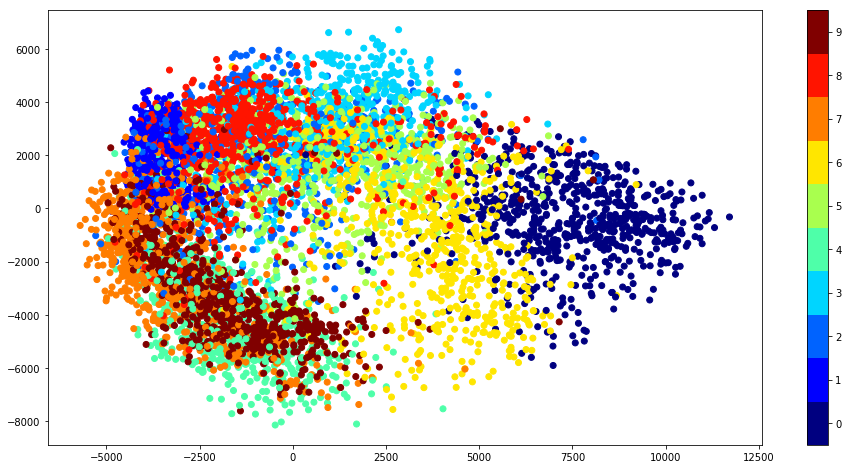

In [46]:
from sklearn.manifold import Isomap
# use only 1/10 of the data: full dataset takes a long time!
data = mnist.data[::10]
target = mnist.target[::10]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.figure(figsize=(16, 8))
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

In [47]:
# Choose 1/4 of the "1" digits to project
def generatePlots(targets):
    plots = []
    model = Isomap(n_components=2)
    for target in targets:
        data = mnist.data[mnist.target == target][::4]
        plots.append(PlotComponents(data, model))
    return plots

plots = generatePlots([1, 2, 3, 4])

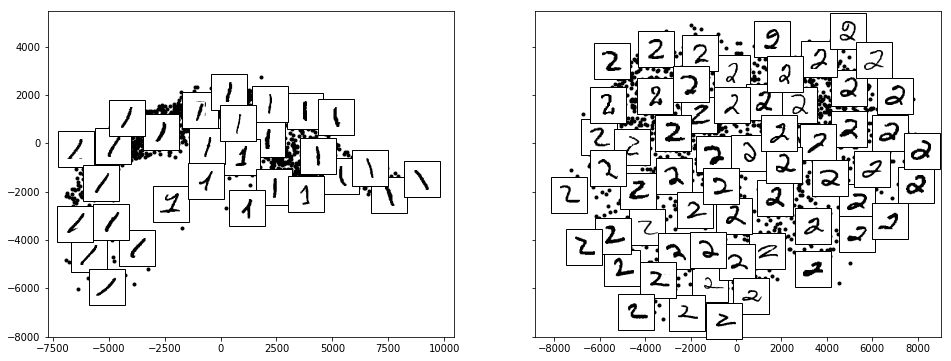

In [48]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
for i in range(2):
    plots[i].plotWithImages(ax[i], cmap='gray_r', thumb_frac=0.08)

The result gives you an idea of the variety of forms that the number "1" can take within the dataset. The data lies along a broad curve in the projected space, which appears to trace the orientation of the digit. As you move up the plot, you find ones that have hats and/or bases, though these are very sparse within the dataset. The projection lets us identify outliers that have data issues: for example, pieces of the neighboring digits that snuck into the extracted images.

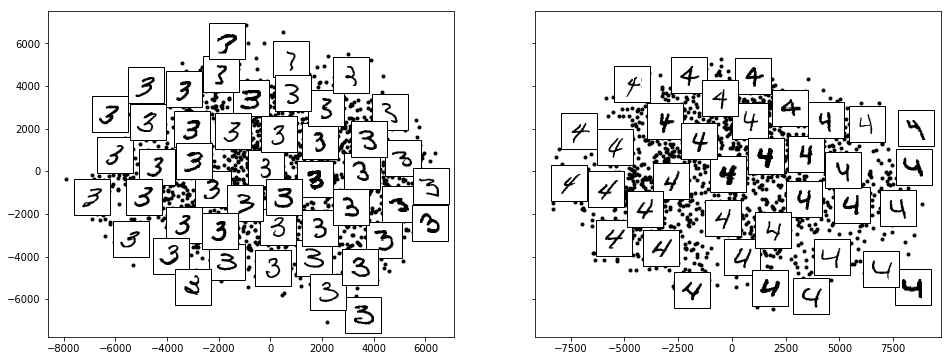

In [49]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
for i in range(2):
    plots[i + 2].plotWithImages(ax[i], cmap='gray_r', thumb_frac=0.1)

In [50]:
otherNumberPlots = generatePlots([5, 6, 7, 8, 9, 0])

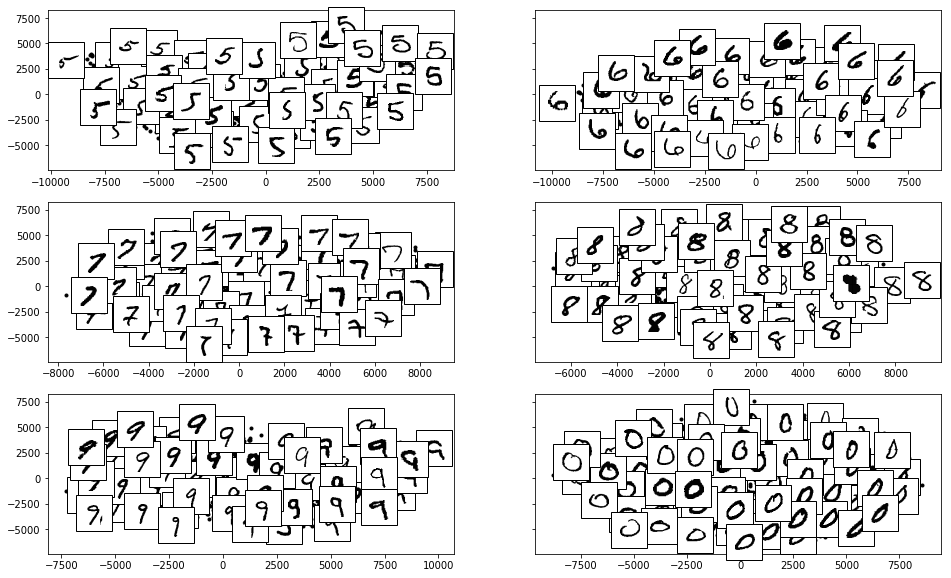

In [51]:
otherFig, otherAx = plt.subplots(3, 2, sharey=True, figsize=(16, 10))
for i in range(3):
    for j in range(2):
        otherNumberPlots[i * 2 + j].plotWithImages(otherAx[i][j], cmap='gray_r', thumb_frac=0.08)

In [12]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)

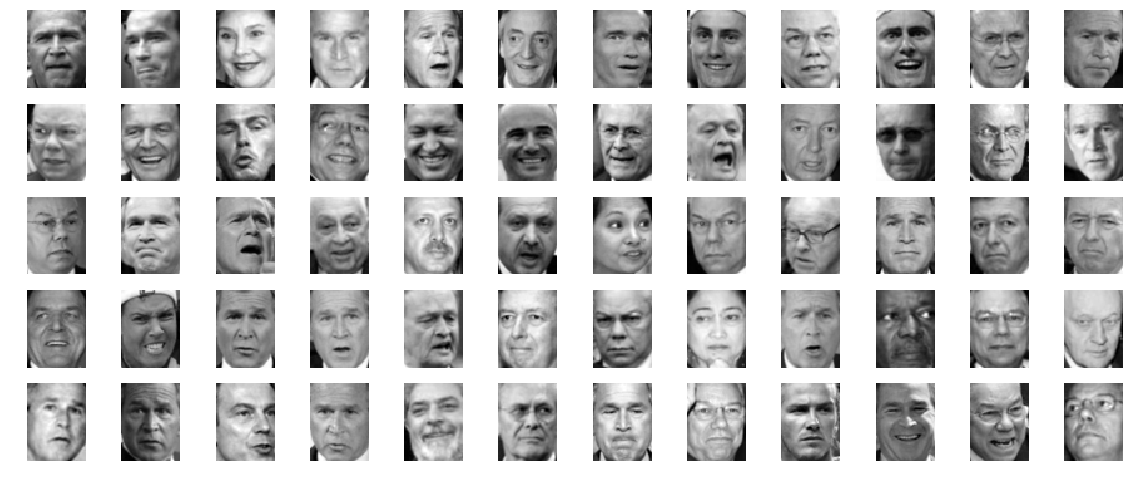

In [13]:
facesImages = []
for i in range(60):
    facesImages.append((faces.images[i], ''))
images = RowImages(facesImages, columns = 12)
images.show(cmap='gray')

In [14]:
facesModel = Isomap(n_components=2)
facesData = faces.data
facesPlot = PlotComponents(facesData, facesModel)

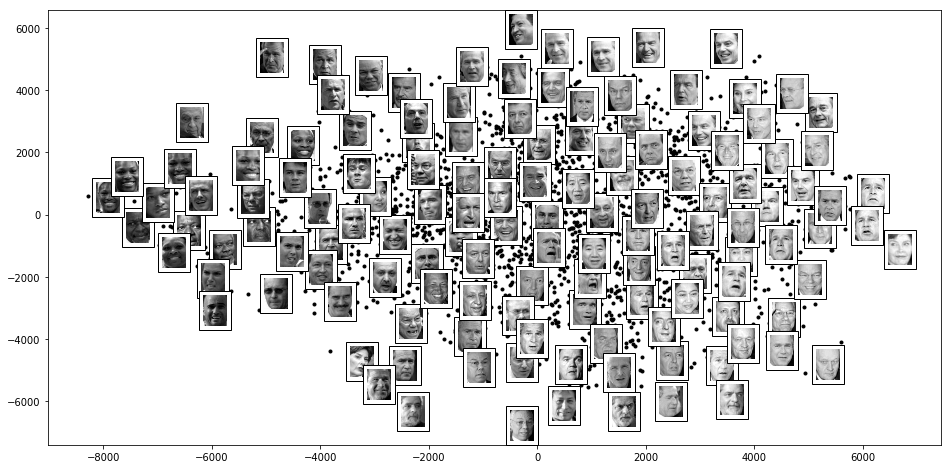

In [15]:
figFaces, axFaces = plt.subplots(figsize=(16, 8))
facesPlot.plotWithImages(axFaces, images=faces.images[:, ::2, ::2])

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top. This gives us a nice visual indication of some of the fundamental features in our data.

In [16]:
putinIndex = np.where(faces.target_names == 'Vladimir Putin')[0][0]
putinData = faces.data[faces.target==putinIndex]

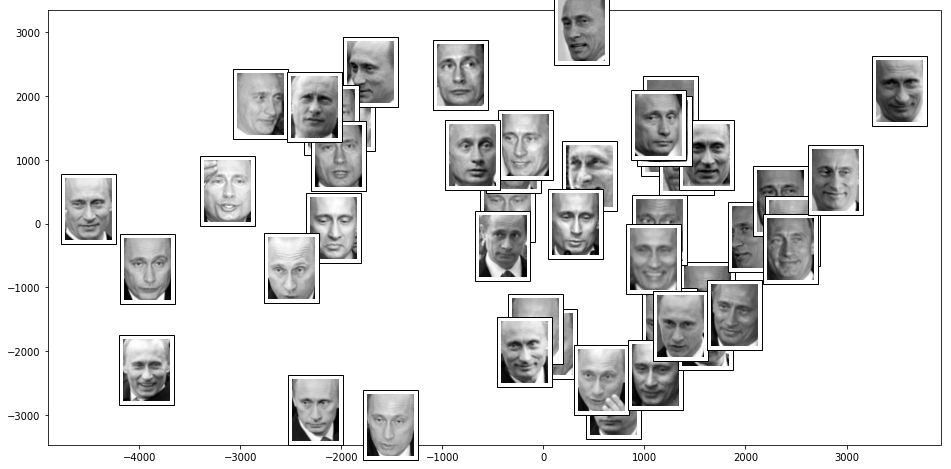

In [17]:
putinModel = Isomap(n_components=2)
putinPlot = PlotComponents(putinData, putinModel)
figPutin, axPutin = plt.subplots(figsize=(16, 8))
putinImages = faces.images[faces.target==putinIndex]
putinPlot.plotWithImages(axPutin, images=putinImages, thumb_frac=0.0, reshape=())

### Classification

Return to digits images.
We have 70000 data points, each an 28x28 image -> 784 dimensional vector.

In [40]:
X = mnist.data[::10]
y = mnist.target[::10]
print(X.shape)
print(y.shape)

(7000, 784)
(7000,)


To evaluate the algorithm, split data into training and testing part

In [41]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print("X_train shape: %s" % repr(X_train.shape))
print("y_train shape: %s" % repr(y_train.shape))
print("X_test shape: %s" % repr(X_test.shape))
print("y_test shape: %s" % repr(y_test.shape))

X_train shape: (5250, 784)
y_train shape: (5250,)
X_test shape: (1750, 784)
y_test shape: (1750,)


In [42]:
isomapModel = Isomap(n_components=2)
fittedIsomapModel = isomapModel.fit(X_train)
projection = isomapModel.transform(X_train)

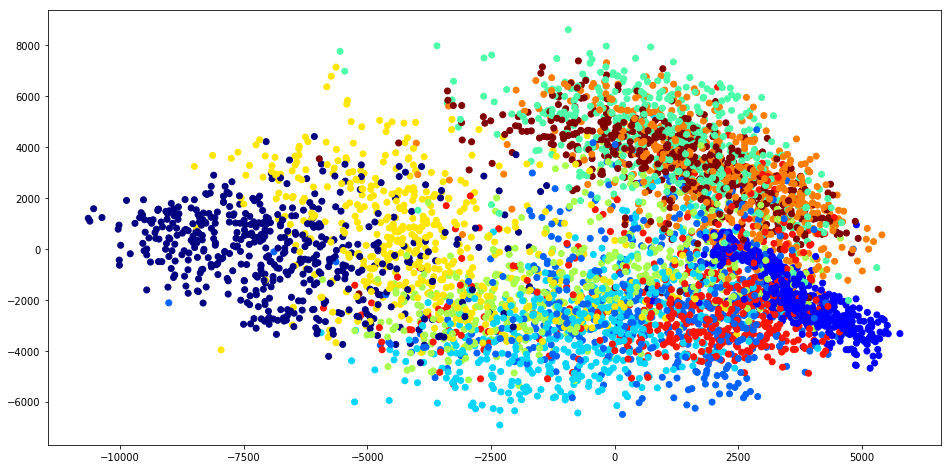

In [43]:
plt.figure(figsize=(16, 8))
plt.scatter(projection[:, 0], projection[:, 1], c=y_train, cmap=plt.cm.get_cmap('jet', 10));

In [44]:
testProjection = isomapModel.transform(X_test)

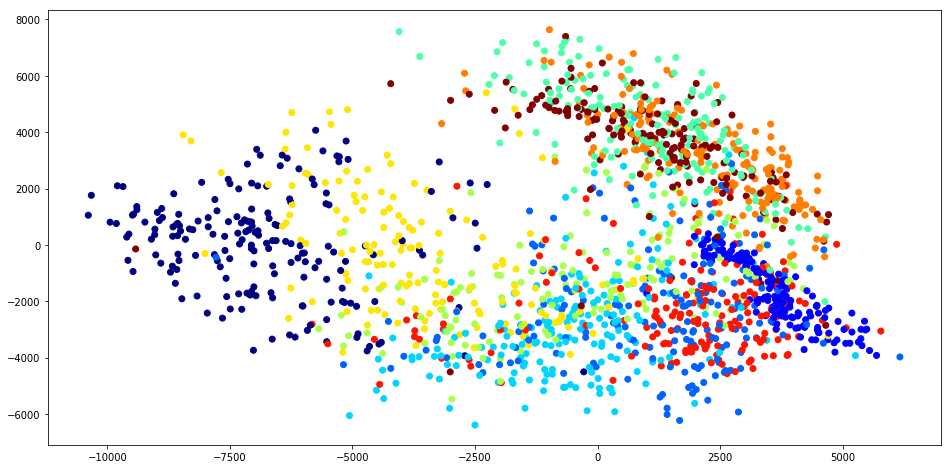

In [45]:
plt.figure(figsize=(16, 8))
plt.scatter(testProjection[:, 0], testProjection[:, 1], c=y_test, cmap=plt.cm.get_cmap('jet', 10));